In [1]:
!pip install tqdm==4.28.1
!pip install -U gast==0.2.2
!pip install gdown

!gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
!mkdir datasets
!tar -C datasets -xzf airport-alunos.tgz


Requirement already up-to-date: gast==0.2.2 in /opt/anaconda3/envs/siamesas/lib/python3.7/site-packages (0.2.2)
Downloading...
From: https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
To: /home/joao/Documents/Doutorado/ammd2-siamesas/airport-alunos.tgz
533MB [01:54, 4.67MB/s] 
mkdir: cannot create directory ‘datasets’: File exists


In [1]:
#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

2.0.0
4.28.1


In [2]:
def base_model(input_shape):
    """
        Model architecture
    """
    
    input_layer = Input(shape = input_shape)
    
    seq_model = Conv2D(8, (3, 3), activation = 'relu')(input_layer)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(16, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(32, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Flatten()(seq_model)
    seq_model = Dense(64)(seq_model)
    
    seq_model = Model(inputs=input_layer, outputs=seq_model)
    
    return seq_model
  
def siamese_model(input_shape):
    
    seq_model = base_model(input_shape)
    
    left_input = Input(shape = input_shape)
    right_input = Input(shape = input_shape)
    
    left_encod = seq_model(left_input)
    right_encod = seq_model(right_input)

    lambda_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    lambda_distance  = lambda_layer([left_encod, right_encod])
    
    return Model(inputs=[left_input,right_input], outputs=lambda_distance)

In [3]:
file_names_treino = !find datasets/airport-alunos/treino -name '???.png' | sort
file_names_val = !find datasets/airport-alunos/val -name '???.png' | sort

print(file_names_treino[:2])
print(file_names_val[:2])

['datasets/airport-alunos/treino/0/000/000.png', 'datasets/airport-alunos/treino/0/000/001.png']
['datasets/airport-alunos/val/0/200/000.png', 'datasets/airport-alunos/val/0/200/001.png']


In [4]:
#load_sample_image('datasets/airport-alunos/treino/0/094/051.png')

#tf.image.decode_image(tf.io.read_file('datasets/airport-alunos/treino/0/094/051.png'))

In [5]:
from dataset_utils import person_to_img
from dataset_utils import combine_cam_files
from dataset_utils import get_batch
from dataset_utils import plot_sample

# carrega imagens para memória
cam_img_dict_treino, pids1_treino, pids2_treino = person_to_img(file_names_treino)
cam_img_dict_val, pids1_val, pids2_val = person_to_img(file_names_val)

Images in cam1 = 14094, cam2 = 14939
Images in cam1 = 2824, cam2 = 3648


In [6]:
# gera listas de similares e dissimilares na memória
d_combination_treino = combine_cam_files(pids1_treino, pids2_treino)
d_combination_val = combine_cam_files(pids1_val, pids2_val)

100%|██████████| 2824/2824 [00:01<00:00, 2078.49it/s]


In [7]:
# obtem pares de batches apartir das imagens em memória
X_a_treino, X_b_treino, y_treino = get_batch(d_combination_treino, cam_img_dict_treino)
X_a_val, X_b_val, y_val = get_batch(d_combination_val, cam_img_dict_val)

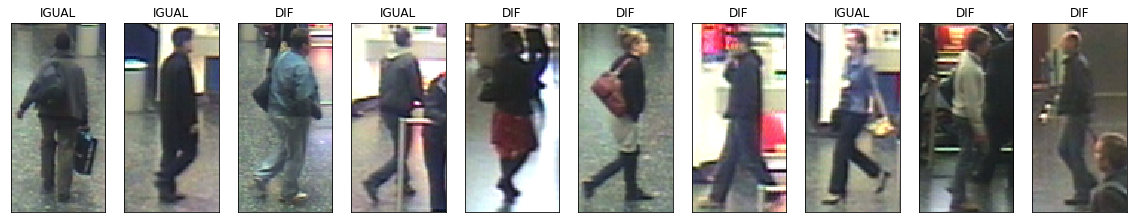

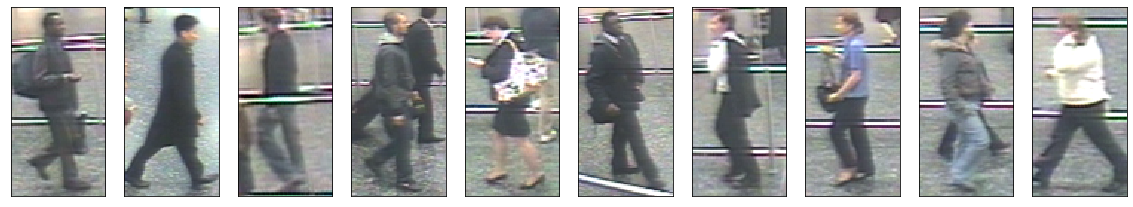

In [8]:
plot_sample(X_a_treino/255, X_b_treino/255, y_treino)

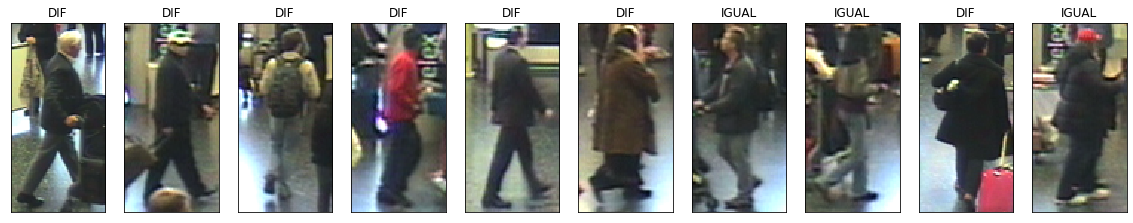

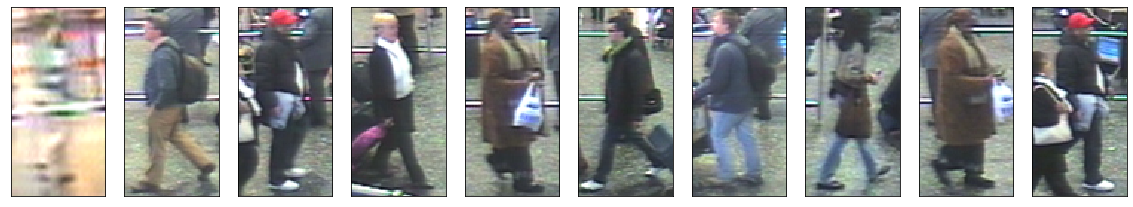

In [9]:
plot_sample(X_a_val/255, X_b_val/255, y_val)

In [10]:
from dataset_utils import load_img
from dataset_utils import img_to_array

In [11]:
img = img_to_array(load_img('datasets/airport-alunos/treino/0/000/000.png'))
img.shape

(128, 64, 3)

In [12]:
img.reshape(img.shape[::-1]).shape

(3, 64, 128)

In [13]:
smodel = siamese_model((128, 64, 3))

In [14]:
smodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64)           29168       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64)           0           model[1][0]                

In [15]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


rms = RMSprop()
smodel.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
smodel.fit([X_a_treino, X_b_treino], y_treino,
          batch_size=50,
          epochs=5,
          validation_data=([X_a_val, X_b_val], y_val))

Train on 14094 samples, validate on 2824 samples
Epoch 1/5
14094/14094 [==============================] - 158s 11ms/sample - loss: 0.3110 - accuracy: 0.5654 - val_loss: 0.3000 - val_accuracy: 0.5735
Epoch 2/5
14094/14094 [==============================] - 138s 10ms/sample - loss: 0.2377 - accuracy: 0.6616 - val_loss: 0.2625 - val_accuracy: 0.6223
Epoch 3/5
14094/14094 [==============================] - 147s 10ms/sample - loss: 0.2107 - accuracy: 0.7004 - val_loss: 0.2641 - val_accuracy: 0.6297
Epoch 4/5
14094/14094 [==============================] - 146s 10ms/sample - loss: 0.1938 - accuracy: 0.7264 - val_loss: 0.2621 - val_accuracy: 0.6348
Epoch 5/5
14094/14094 [==============================] - 151s 11ms/sample - loss: 0.1817 - accuracy: 0.7452 - val_loss: 0.2335 - val_accuracy: 0.6698


In [17]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

# compute final accuracy on training and test sets
y_pred = smodel.predict([X_a_treino, X_b_treino])
tr_acc = compute_accuracy(y_treino, y_pred)
y_pred = smodel.predict([X_a_val, X_b_val])
te_acc = compute_accuracy(y_val, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))


/opt/anaconda3/envs/siamesas/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


* Accuracy on training set: 0.00%
* Accuracy on test set: 0.00%


In [ ]:
X_b_treino.shape